In [1]:
!pip install adjustText
!pip install biopython
!pip install dmslogo

from google.colab import output
output.clear()

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import to_rgba
import gzip
from functools import partial
import ast
import dmslogo
import random

import arviz as az
import seaborn as sns
import scipy.cluster.hierarchy as hierarchy
import scipy.sparse as sparse
import scipy.stats as stats
from scipy import spatial

import Bio
from Bio import motifs
from operator import itemgetter
import networkx as nx
from networkx.algorithms import bipartite

from sklearn.datasets import make_biclusters
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score

from adjustText import adjust_text

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)

from tqdm.auto import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')


import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

No GPU available


In [3]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

class utils():
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

In [4]:
#--- BODA library
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)
no_controls_df = boda2_df[boda2_df['method'].notnull()].reset_index(drop=True)

#For sorting purposes
no_controls_df = no_controls_df.sort_values('ID')

sequence_column_name = 'sequence'
contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']
onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in tqdm(no_controls_df[sequence_column_name].tolist())])

contribution_tensor = []
for contribution_column in tqdm(contribution_columns):
    flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
                                      for contributions in no_controls_df[contribution_column]])
    contribution_tensor.append(flat_contributions * onehot_sequences)
contribution_tensor = torch.stack(contribution_tensor)

#--- Motif programs
programs = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/STREME_topic_modeling/BODA_topics.txt',
                         sep='\t', header=0, index_col=0)
programs = programs / programs.sum(axis=0)
program_columns = [str(i) for i in range(13)]

#--- Sequence programs
seq_programs = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/STREME_topic_modeling/BODA_sequence_topics.txt',
                         sep='\t', header=0, index_col=0)
seq_programs = seq_programs.reset_index()
seq_programs = seq_programs.rename({'id':'ID'}, axis=1)

#-------------------------------------------------- Old motifs --------------------------------------------------
# #--- STREME motifs
# boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_ultimate_merge.txt', sep=" ", low_memory=False)
# boda2_streme_tfs.at[0, 'contribution_HepG2'] = boda2_streme_tfs.iloc[0]['contribution_HepG2'] / 2

# # boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_contributions.txt', sep=" ", low_memory=False)
# # boda2_streme_tfs.at[0, 'contribution_HepG2'] = boda2_streme_tfs.iloc[0]['contribution_HepG2'] / 2
# # short_names_with_distinction = [f'S-{i+1} ({short_name})' for i, short_name in enumerate(boda2_streme_tfs['Target_ID_short'].tolist())]
# # boda2_streme_tfs['Target_ID_short'] = short_names_with_distinction

# boda2_streme_tfs_logos = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_processed.txt', sep=" ", low_memory=False)

# df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
# for df_array_column in tqdm(df_array_columns):
#     boda2_streme_tfs_logos[df_array_column] = boda2_streme_tfs_logos.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

# #--- FIMO
# fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo.tsv', sep='\t')
# fimo_df = fimo_df[:-3].reset_index(drop=True)
#-----------------------------------------------------------------------------------------------------------------------

#--- STREME min8 motifs
boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/STREME_min8_TFs_merge.txt', sep=" ", low_memory=False)
#boda2_streme_tfs.at[0, 'contribution_HepG2'] = boda2_streme_tfs.iloc[0]['contribution_HepG2'] / 2

# boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_contributions.txt', sep=" ", low_memory=False)
# boda2_streme_tfs.at[0, 'contribution_HepG2'] = boda2_streme_tfs.iloc[0]['contribution_HepG2'] / 2
# short_names_with_distinction = [f'S-{i+1} ({short_name})' for i, short_name in enumerate(boda2_streme_tfs['Target_ID_short'].tolist())]
# boda2_streme_tfs['Target_ID_short'] = short_names_with_distinction

boda2_streme_tfs_logos = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/STREME_min8_TFs_processed.txt', sep=" ", low_memory=False)

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    boda2_streme_tfs_logos[df_array_column] = boda2_streme_tfs_logos.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

#--- FIMO min8
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_min8.tsv', sep='\t')
fimo_df = fimo_df[:-3].reset_index(drop=True)

  0%|          | 0/117900 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

# Type/Token ratios

In [5]:
matches = fimo_df.groupby('sequence_name').motif_alt_id.apply(list).reset_index()
matches.rename({'sequence_name':'ID'}, axis=1, inplace=True)

In [6]:
matches_df = matches.merge(boda2_df, on='ID', how='inner')

In [7]:
matches_df['token'] = matches_df.progress_apply(lambda x: len(x['motif_alt_id']), axis=1)
matches_df['type'] = matches_df.progress_apply(lambda x: len(set(x['motif_alt_id'])), axis=1)

matches_df['type/token'] = matches_df['type'] / matches_df['token']

  0%|          | 0/118968 [00:00<?, ?it/s]

  0%|          | 0/118968 [00:00<?, ?it/s]

In [8]:
dhs_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/DHS.Control.Satellite.Simple.Repeats.txt', sep='\t')
mal_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/Malinois.Natural.Satellite.Simple.Repeats.txt', sep='\t')

dhs_annotation_df['Seq ID'] = [x[0] for x in dhs_annotation_df['Seq ID'].str.split(':')]
mal_annotation_df['Seq ID'] = [(':').join(x[:2]) for x in mal_annotation_df['Seq ID'].str.split(':').tolist()]

repetitive_seqs = set(dhs_annotation_df['Seq ID'].tolist() + mal_annotation_df['Seq ID'].tolist())

In [9]:
row_filter = matches_df['method'].isin(['DHS', 'gs'])
truncated_ids = [x[0] for x in matches_df.loc[row_filter]['ID'].str.split('::').tolist()]
matches_df.loc[row_filter, 'truncated_id'] = truncated_ids

59570


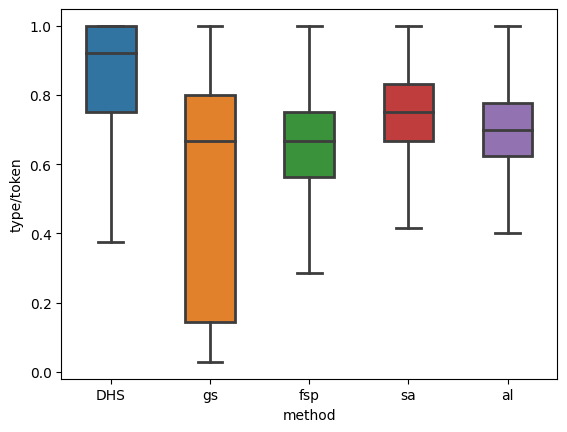

In [10]:
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)
# quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = plot_df[quality_filter].reset_index(drop=True)
print(len(plot_df))

with plt.style.context('fast'):
    mpl.rcParams['lines.linewidth'] = 2.0
    sns.boxplot(data=plot_df, x='method', y='type/token', showfliers=False, order=methods, width=0.5)
    plt.show()

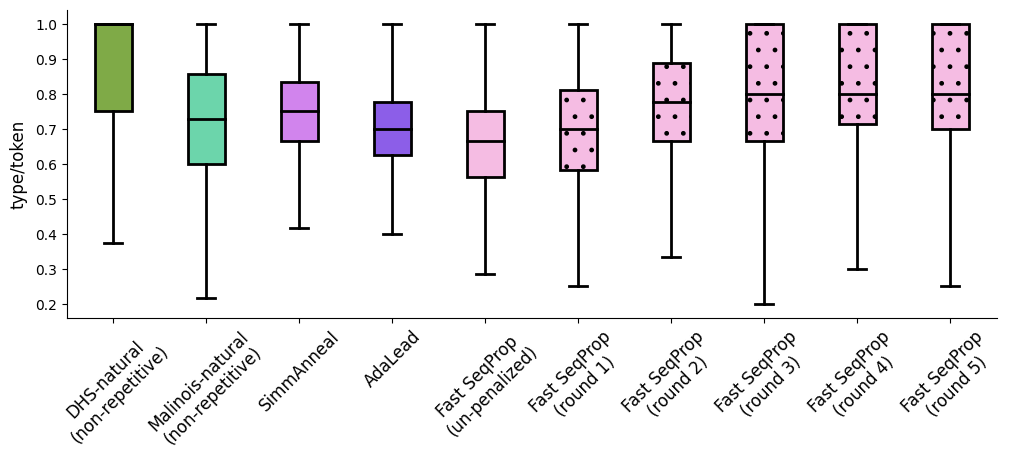

In [11]:
conditon_1 = matches_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (matches_df['round'] == 0)
condition_2 = matches_df['method'] == 'fsp'
plot_df = matches_df[conditon_1 | condition_2].reset_index(drop=True)

plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)


row_filter = plot_df['method'] == 'fsp'
plot_df.loc[row_filter, 'method'] = 'Fast SeqProp\nround ' + plot_df[row_filter]['round'].astype(str)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order = ['DHS', 'gs', 'sa', 'al', 'Fast SeqProp\nround 0', 'Fast SeqProp\nround 1',
       'Fast SeqProp\nround 2', 'Fast SeqProp\nround 3',
       'Fast SeqProp\nround 4', 'Fast SeqProp\nround 5']
ordered_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']
hatches = 5*[''] + 5*['.']
with plt.style.context('fast'):
    plt.figure(figsize=(12,4))
    mpl.rcParams['lines.linewidth'] = 2.0
    g = sns.boxplot(data=plot_df, x='method', y='type/token', showfliers=False, order=order, width=0.4, palette=ordered_colors, **PROPS)
    patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
    h = hatches * (len(patches) // len(hatches))
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        patch.set_edgecolor('k')
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    plt.xlabel('')
    g.set_xticklabels(['DHS-natural\n(non-repetitive)', 'Malinois-natural\n(non-repetitive)', 'SimmAnneal', 'AdaLead', 'Fast SeqProp\n(un-penalized)',
                       'Fast SeqProp\n(round 1)', 'Fast SeqProp\n(round 2)', 'Fast SeqProp\n(round 3)', 'Fast SeqProp\n(round 4)', 'Fast SeqProp\n(round 5)'],
                      fontsize=12, rotation=45)
    plt.ylabel('type/token', labelpad=5, fontsize=12)
    savepath = f'/content/drive/MyDrive/figures/type_token/type_token_all_methods_boxplot.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    plt.show()

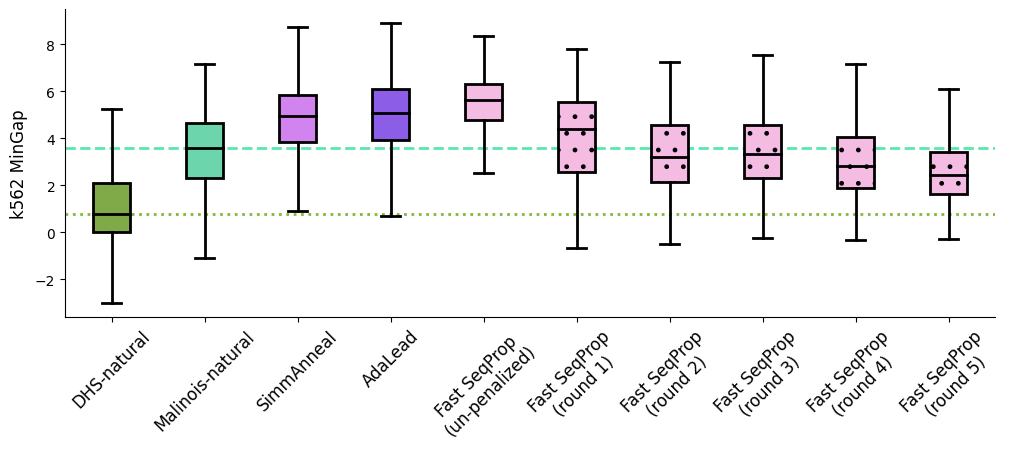

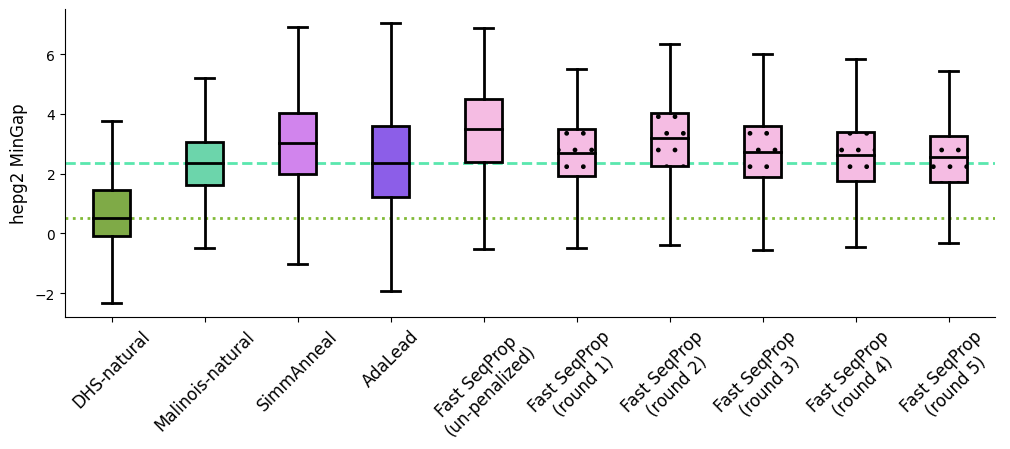

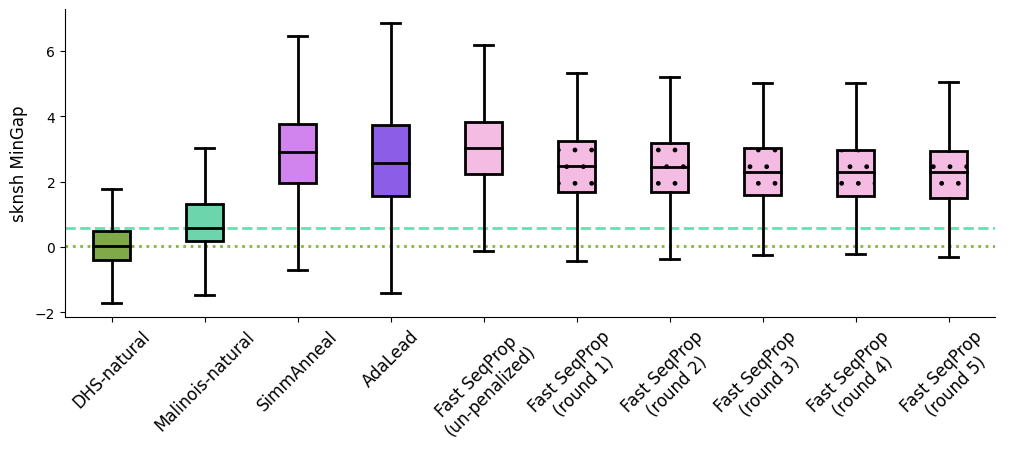

In [12]:
conditon_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
condition_2 = boda2_df['method'] == 'fsp'
plot_df = boda2_df[conditon_1 | condition_2].reset_index(drop=True)

#plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

row_filter = plot_df['method'] == 'fsp'
plot_df.loc[row_filter, 'method'] = 'Fast SeqProp\nround ' + plot_df[row_filter]['round'].astype(str)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order = ['DHS', 'gs', 'sa', 'al', 'Fast SeqProp\nround 0', 'Fast SeqProp\nround 1',
       'Fast SeqProp\nround 2', 'Fast SeqProp\nround 3',
       'Fast SeqProp\nround 4', 'Fast SeqProp\nround 5']
ordered_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']
hatches = 5*[''] + 5*['.']

target_cells = ['k562', 'hepg2', 'sknsh']
for target_cell in target_cells:
    with plt.style.context('fast'):
        plt.figure(figsize=(12,4))
        mpl.rcParams['lines.linewidth'] = 2.0
        temp_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
        med = temp_df[temp_df['method'] == 'gs']['OverMax'].median()
        med_2 = temp_df[temp_df['method'] == 'DHS']['OverMax'].median()
        plt.hlines(med, -0.5, 9.5, linestyle='dashed', color=ordered_colors[1], zorder=0, alpha=1)
        plt.hlines(med_2, -0.5, 9.5, linestyle='dotted', color=ordered_colors[0], zorder=0, alpha=1)
        g = sns.boxplot(data=temp_df, x='method', y='OverMax', showfliers=False, order=order, width=0.4, palette=ordered_colors, **PROPS)
        patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
        h = hatches * (len(patches) // len(hatches))
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            patch.set_edgecolor('k')
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        plt.xlabel('')
        g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'SimmAnneal', 'AdaLead', 'Fast SeqProp\n(un-penalized)',
                        'Fast SeqProp\n(round 1)', 'Fast SeqProp\n(round 2)', 'Fast SeqProp\n(round 3)', 'Fast SeqProp\n(round 4)', 'Fast SeqProp\n(round 5)'],
                        fontsize=12, rotation=45)
        plt.ylabel(f'{target_cell} MinGap', labelpad=5, fontsize=12)
        savepath = f'/content/drive/MyDrive/figures/MinGap/MinGap_all_methods_boxplot_{target_cell}.pdf'
        plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
        plt.show()

In [13]:
plot_df[plot_df['method'] == 'gs']['OverMax'].median()

2.0391346210055907

56778


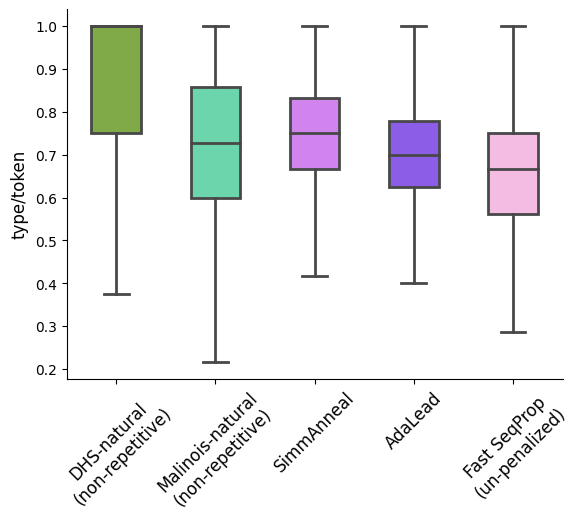

In [14]:
methods = ['DHS', 'gs', 'sa', 'al', 'fsp']
ordered_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF', '#FFB2E6']

plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)
plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)
# quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = plot_df[quality_filter].reset_index(drop=True)
print(len(plot_df))

with plt.style.context('fast'):
    mpl.rcParams['lines.linewidth'] = 2.0
    g = sns.boxplot(data=plot_df, x='method', y='type/token', showfliers=False, order=methods, width=0.5, palette=ordered_colors)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    plt.xlabel('')
    g.set_xticklabels(['DHS-natural\n(non-repetitive)', 'Malinois-natural\n(non-repetitive)', 'SimmAnneal', 'AdaLead', 'Fast SeqProp\n(un-penalized)'], fontsize=12, rotation=45)
    plt.ylabel('type/token', labelpad=5, fontsize=12)
    plt.show()

In [15]:
color_dict = {
  'penalized': '#FFB2E6',
  'gradient': '#FFB2E6',
  'probabilistic': '#D972FF',
  'evolutionary': '#8447FF',
  'Malinois_natural': '#33D15B',
  'DHS_natural': '#57954A',
  'all_naturals': '#5B9EDD',
  'all_synthetics': '#FF6D79',
}

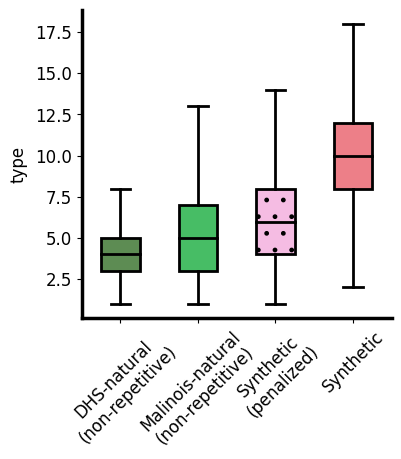

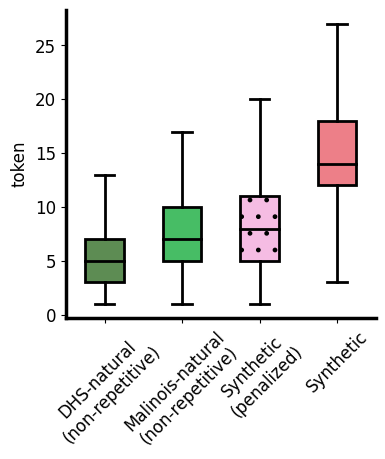

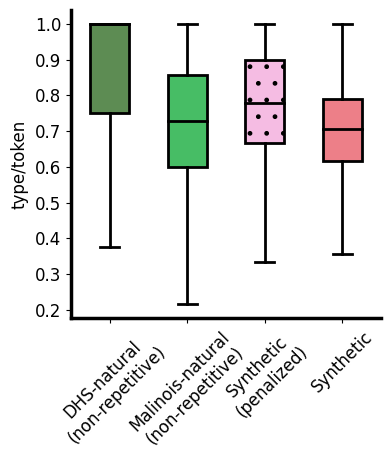

In [16]:
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
#colors = ['dimgray', 'darkgray', 'lightgrey', 'lightgrey' ]
colors = [color_dict['DHS_natural'], color_dict['Malinois_natural'], color_dict['gradient'], color_dict['all_synthetics']]

plot_df = matches_df.copy()
plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)

dhs_rows = plot_df['method'].isin(['DHS'])
plot_df.loc[dhs_rows, 'origin_tag'] = 'DHS'

gs_rows = plot_df['method'].isin(['gs'])
plot_df.loc[gs_rows, 'origin_tag'] = 'Genome scan'

synth_penalized = plot_df['method'].isin(['fsp']) & (plot_df['round'] != 0)
#synth_penalized = plot_df['method'].isin(['sa_rep'])                                       #Compare sa_rep
plot_df.loc[synth_penalized, 'origin_tag'] = 'Synthetic (penalized)'

synth_non_penalized = plot_df['method'].isin(['al', 'sa', 'fsp']) & (plot_df['round'] == 0)
#synth_non_penalized = plot_df['method'].isin(['sa'])                                        #Compare sa_rep
plot_df.loc[synth_non_penalized, 'origin_tag'] = 'Synthetic'

order = ['DHS', 'Genome scan', 'Synthetic (penalized)', 'Synthetic']
# quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = plot_df[quality_filter].reset_index(drop=True)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

hatches = ['', '', '.', '']
for column in ['type', 'token', 'type/token']:
# for target_cell in target_cells:
#     temp_plot_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
    temp_plot_df = plot_df.copy()
    with plt.style.context('fast'):
        #mpl.rc('axes',edgecolor='#002D72')
        mpl.rcParams['lines.linewidth'] = 2.0
        plt.figure(figsize=(4,4))
        g = sns.boxplot(data=temp_plot_df, x='origin_tag', y=column, #k_depth='full',
                        order=order, palette=colors, width=0.5,
                        showfliers=False, **PROPS
                        )
        patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
        h = hatches * (len(patches) // len(hatches))
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            patch.set_edgecolor('k')
        #g.set(xticklabels=[])
        plt.xlabel('')
        #plt.xticks([])
        #plt.ylabel('')
        plt.yticks(fontsize=12)#, color='#002D72')
        for _,s in g.spines.items():
            s.set_linewidth(2.5)
            #s.set_color('#002D72')
        #plt.ylim(-6.5, 9)
        plt.ylabel(column, labelpad=5, fontsize=12)
        #plt.title(target_cell, fontsize=18, y=1.05)
        #plt.xlabel("", labelpad=10)
        #g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic'], fontsize=16)
        g.set_xticklabels(['DHS-natural\n(non-repetitive)', 'Malinois-natural\n(non-repetitive)', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=12, rotation=45)
        #g.set_xticklabels(['DHS', 'Genome scan', 'SA (rep)', 'SA'], fontsize=16)                   #Compare sa_rep
        #plt.xticks(rotation=50)
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        #g.spines['left'].set_visible(False)

        flat_column = column.replace('/', '_')
        savepath = f'/content/drive/MyDrive/figures/type_token/{flat_column}_boxplots.pdf'
        plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
        plt.show()

In [ ]:
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)
# quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = plot_df[quality_filter].reset_index(drop=True)
plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)

synthetics_df = plot_df[plot_df['method'].isin(['fsp', 'sa', 'al'])].reset_index(drop=True)
naturals_df = plot_df[plot_df['method'].isin(['DHS', 'gs'])].reset_index(drop=True)

In [ ]:
type_pvalue = stats.ranksums(synthetics_df['type'].to_numpy(), naturals_df['type'].to_numpy(), alternative='greater', nan_policy='omit')
token_pvalue = stats.ranksums(synthetics_df['token'].to_numpy(), naturals_df['token'].to_numpy(), alternative='greater', nan_policy='omit')

print(type_pvalue)
print(token_pvalue)
print('')
print(synthetics_df['type'].median() / naturals_df['type'].median())
print(synthetics_df['token'].median() / naturals_df['token'].median())

RanksumsResult(statistic=166.76847076650728, pvalue=0.0)
RanksumsResult(statistic=162.95048458199744, pvalue=0.0)

2.5
2.3333333333333335


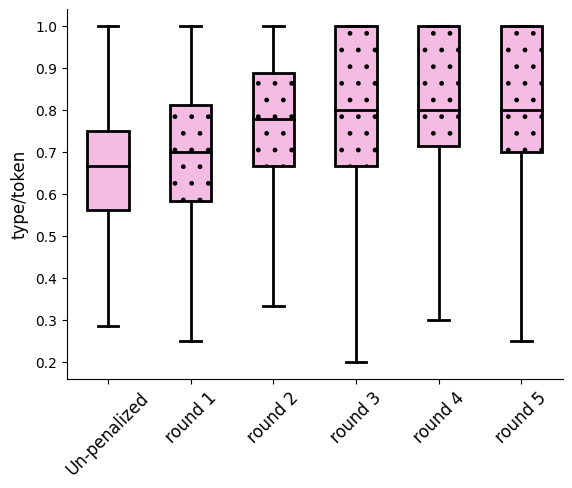

In [ ]:
methods = ['fsp']#, 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods)].reset_index(drop=True)
# quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = plot_df[quality_filter].reset_index(drop=True)

#custom_palette = sns.color_palette("magma_r", 6)
custom_palette = 6*[ordered_colors[-1]]
hatches = [''] + 5*['.']

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
with plt.style.context('fast'):
    mpl.rcParams['lines.linewidth'] = 2.0
    g = sns.boxplot(data=plot_df, x='round', y='type/token', showfliers=False, width=0.5, palette=custom_palette, **PROPS)

    patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
    h = hatches * (len(patches) // len(hatches))
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        patch.set_edgecolor('k')

    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    g.set_xticklabels(['Un-penalized', 'round 1', 'round 2', 'round 3', 'round 4', 'round 5'], fontsize=12, rotation=45)
    plt.xlabel('')
    plt.ylabel('type/token', labelpad=5, fontsize=12)
    #plt.title("Fast SeqProp sequences")
    plt.show()

PearsonRResult(statistic=0.3938647600695617, pvalue=0.0)
SignificanceResult(statistic=0.40021668358834994, pvalue=0.0)


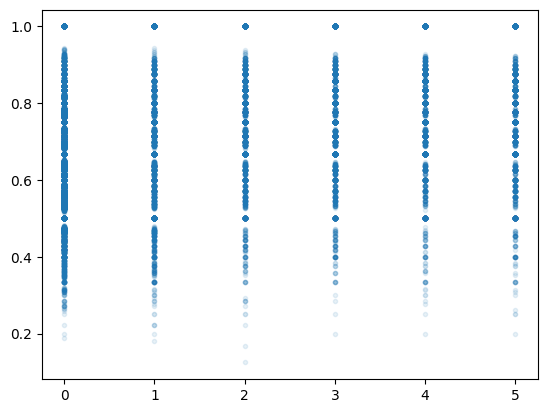

In [ ]:
print(stats.pearsonr(plot_df['round'].to_numpy(), plot_df['type/token'].to_numpy()))
print(stats.spearmanr(plot_df['round'].to_numpy(), plot_df['type/token'].to_numpy()))
plt.scatter(plot_df['round'].to_numpy(), plot_df['type/token'].to_numpy(), marker='.', alpha=0.1)
plt.show()

In [ ]:
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods)].reset_index(drop=True)
# quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = plot_df[quality_filter].reset_index(drop=True)
plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)

synthetics_df = plot_df[plot_df['method'].isin(['fsp', 'sa', 'al']) & (plot_df['round'] == 0)].reset_index(drop=True)
synthetics_df_2 = plot_df[plot_df['method'].isin(['fsp']) & (plot_df['round'] != 0)].reset_index(drop=True)
naturals_df = plot_df[plot_df['method'].isin(['DHS', 'gs'])].reset_index(drop=True)

type_pvalue = stats.ranksums(synthetics_df['type'].to_numpy(), synthetics_df_2['type'].to_numpy(), alternative='greater', nan_policy='omit')
token_pvalue = stats.ranksums(synthetics_df['token'].to_numpy(), synthetics_df_2['token'].to_numpy(), alternative='greater', nan_policy='omit')

print(type_pvalue)
print(token_pvalue)
print('')
print(synthetics_df['type'].median() / synthetics_df_2['type'].median())
print(synthetics_df['token'].median() / synthetics_df_2['token'].median())
print('')
print(synthetics_df_2['type'].median() / naturals_df['type'].median())
print(synthetics_df_2['token'].median() / naturals_df['token'].median())
print('')
print(synthetics_df['type'].median() / naturals_df['type'].median())
print(synthetics_df['token'].median() / naturals_df['token'].median())


RanksumsResult(statistic=124.93393958135657, pvalue=0.0)
RanksumsResult(statistic=130.04248370086464, pvalue=0.0)

1.6666666666666667
1.75

1.5
1.3333333333333333

2.5
2.3333333333333335


In [ ]:
type_token_pvalue = stats.ranksums(synthetics_df_2['type/token'].to_numpy(), synthetics_df['type/token'].to_numpy(), alternative='greater', nan_policy='omit')

print(type_token_pvalue)
print('')
print(synthetics_df['type/token'].median())
print(synthetics_df_2['type/token'].median())

RanksumsResult(statistic=50.194347168042455, pvalue=0.0)

0.7058823529411765
0.7777777777777778


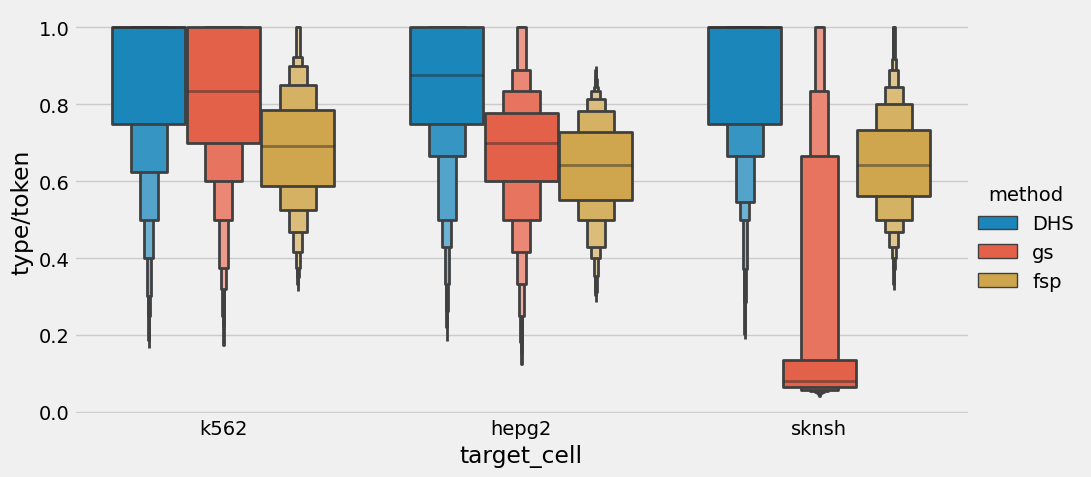

In [ ]:
methods = ['DHS', 'gs', 'fsp']#, 'sa', 'al']
target_cells = ['k562', 'hepg2', 'sknsh']

plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

colors = ['lightgrey', 'darkgray', 'dimgray']
temp_df = plot_df[['type/token', 'method', 'target_cell']]
with plt.style.context('fivethirtyeight'):
    mpl.rcParams['lines.linewidth'] = 2.0
    sns.catplot(data=temp_df, x='target_cell', y='type/token', hue='method', kind="boxen", #palette=reversed(colors),
                showfliers=False, hue_order=methods, order=target_cells, width=0.75, aspect=2.
                )
    plt.show()

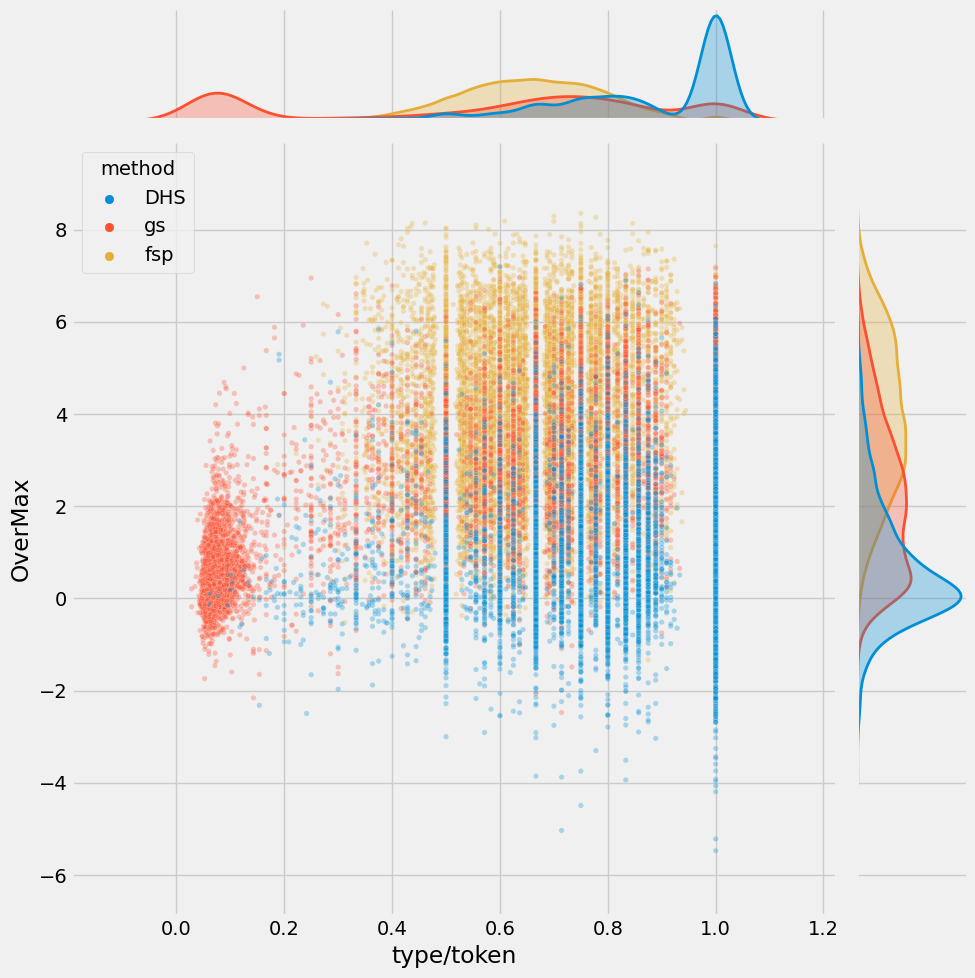

In [ ]:
methods = ['DHS', 'gs', 'fsp']#, 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

with plt.style.context('fivethirtyeight'):
    sns.jointplot(data=plot_df, x='type/token', y='OverMax', hue='method', hue_order=methods, height=10, ratio=6,
                  marginal_kws={'linewidth':2, 'common_grid':False, 'common_norm':False, 'alpha':0.3},
                  joint_kws={'s':15, 'alpha':0.3},
                  )
    plt.show()

In [ ]:
plot_df

,ID,motif_alt_id,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH,token,type,type/token,truncated_id,origin_tag
0,20211206_221956__59439361__0::al__k562__0,"[STREME-11, STREME-10, STREME-5, STREME-22, ST...",TCGAAGCGATGTAATCACCCATGAACTGTCTCTCCAAGAGTAGCAA...,BODA:k562,al,0,6.465092,-1.307851,-1.654066,0.412323,0.440709,0.314627,677.344043,677.344043,677.344043,59842.375699,273.581062,215.043090,8.177629,-2.185843,-2.216086,7.681528,-1.892751,-1.953348,k562,k562,k562,6.465092,hepg2,-1.307851,sknsh,-1.654066,-1.480959,7.946051,7.772944,[ 2.80367304e-02 -1.04044311e-01 -7.10074231e-...,[-6.15489557e-02 -1.46338493e-01 -4.68237624e-...,[-7.78070837e-02 -1.47157282e-01 -4.04657573e-...,23,14,0.608696,NaN,Synthetic
1,20211206_221956__59439361__1000::al__k562__0,"[STREME-22, STREME-25, STREME-10, STREME-23, S...",CCCGCCGCTTGGTGCGCCTTATCTACACAGGACTTCTCGGTTTTCC...,BODA:k562,al,0,5.903565,-0.933139,-1.324058,0.382468,0.438618,0.327163,1014.011975,1014.011975,1014.011975,60703.795166,531.061114,405.067901,8.342083,-2.167171,-2.118229,6.726991,-1.853611,-1.797837,k562,k562,k562,5.903565,hepg2,-0.933139,sknsh,-1.324058,-1.128598,7.032163,6.836704,[-0.027576234 0.006964267 -0.0061448514 ...,[-0.030464739 -0.052886978 -0.020159554 ...,[-2.9014692e-02 -2.8253801e-02 -5.5667918e-02 ...,13,11,0.846154,NaN,Synthetic
2,20211206_221956__59439361__1001::al__k562__0,"[STREME-25, STREME-5, STREME-16, STREME-22, ST...",GATGTAAGATAAGGCAGTTCTAGGAATTTGGGTCGGTCATCGGTTT...,BODA:k562,al,0,4.569213,-0.632219,-1.625793,0.383084,0.357284,0.243759,1192.249352,1192.249352,1192.249352,28305.217332,769.220785,386.130779,6.218562,-2.311238,-2.207346,5.587542,-1.928826,-1.919173,k562,k562,k562,4.569213,hepg2,-0.632219,sknsh,-1.625793,-1.129006,5.698219,5.201432,[ 7.27560148e-02 3.26064718e-03 -2.25046155e-...,[-2.62967795e-02 4.10473756e-02 -5.51284142e-...,[-1.04328152e-03 6.37289435e-02 -2.00211667e-...,14,9,0.642857,NaN,Synthetic
3,20211206_221956__59439361__1002::al__k562__0,"[STREME-11, STREME-34, STREME-23, STREME-32, S...",GCTACCGTCGACCGTCTGTCACTACTTCGTTTTCCCGCCAAAAAAG...,BODA:k562,al,0,2.207518,-1.118060,-1.867654,0.353022,0.410465,0.354331,1294.055374,1294.055374,1294.055374,5978.458025,596.178037,354.686917,6.944439,-2.126097,-2.127545,6.508156,-1.624164,-1.725366,k562,k562,k562,2.207518,hepg2,-1.118060,sknsh,-1.867654,-1.492857,3.700375,3.325579,[-0.035198063 -0.00864079 -0.007486275 ...,[-3.18061151e-02 -5.38216457e-02 -4.30142134e-...,[-0.043307647 -0.03959865 -0.02948765 ...,15,11,0.733333,NaN,Synthetic
4,20211206_221956__59439361__1003::al__k562__0,"[STREME-10, STREME-27, STREME-28, STREME-10, S...",TCAATTGAGAAACCGCACATATGTCTTGTCTAGATAACAGGCCTTT...,BODA:k562,al,0,4.104297,-1.229394,-0.763679,0.361999,0.390237,0.297383,573.172432,573.172432,573.172432,9859.146240,244.434138,337.879436,6.214275,-2.262512,-2.153637,5.094973,-2.011996,-1.915264,k562,k562,k562,4.104297,sknsh,-0.763679,hepg2,-1.229394,-0.996537,5.100834,4.867977,[ 0.31063223 0.15897503 0.23637305 ...,[ 0.057097904 0.0034336976 0.112397335 ...,[ 9.07720625e-03 -2.81717777e-02 5.77392317e-...,21,15,0.714286,NaN,Synthetic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89512,control_DHS_S_9944::chr12:98644710-98644910,"[STREME-63, STREME-62, STREME-60, STREME-8, ST...",CCCTAGGACGACAAGCCCAGGGCAGCTTCTTCACCAGGGGGAGCAG...,BODA:DHS_ctrl:sknsh,DHS,0,3.813217,2.938436,4.199068,0.272299,0.325700,0.266228,37.526725,37.526725,37.526725,528.950

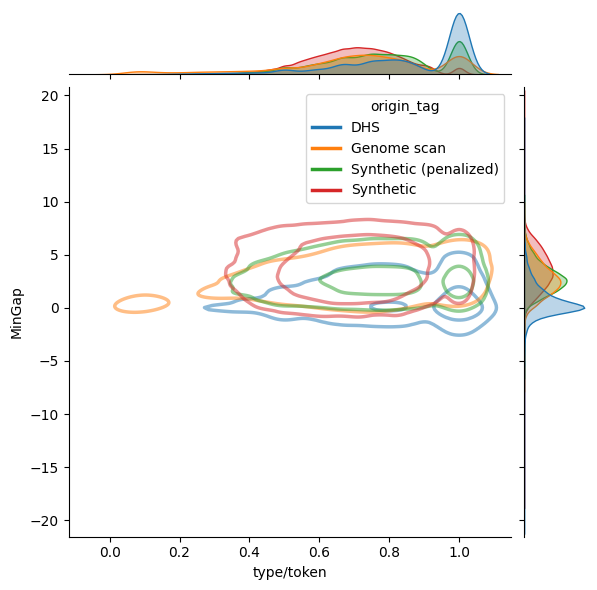

In [ ]:
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods)].reset_index(drop=True)

dhs_rows = plot_df['method'].isin(['DHS'])
plot_df.loc[dhs_rows, 'origin_tag'] = 'DHS'

gs_rows = plot_df['method'].isin(['gs'])
plot_df.loc[gs_rows, 'origin_tag'] = 'Genome scan'

synth_penalized = plot_df['method'].isin(['fsp']) & (plot_df['round'] != 0)
#synth_penalized = plot_df['method'].isin(['sa_rep'])                                       #Compare sa_rep
plot_df.loc[synth_penalized, 'origin_tag'] = 'Synthetic (penalized)'

synth_non_penalized = plot_df['method'].isin(['al', 'sa', 'fsp']) & (plot_df['round'] == 0)
#synth_non_penalized = plot_df['method'].isin(['sa'])                                        #Compare sa_rep
plot_df.loc[synth_non_penalized, 'origin_tag'] = 'Synthetic'

#plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)
# quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = plot_df[quality_filter].reset_index(drop=True)
plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)

order = ['DHS', 'Genome scan', 'Synthetic (penalized)', 'Synthetic']
with plt.style.context('fast'):
    mpl.rcParams['lines.linewidth'] = 2.5
    sns.jointplot(data=plot_df, x='type/token', y='OverMax', hue='origin_tag', hue_order=order, height=6, ratio=6, kind='kde',
                  marginal_kws={'linewidth':1, 'common_grid':False, 'common_norm':False, 'alpha':0.3, 'fill':True},
                  joint_kws={'alpha':0.5, 'levels':np.array([0.05, 0.5])}, #joint_kws={'s':15, 'alpha':0.5, 'linewidth':1, 'levels':np.array([0.05])}
                  )
    plt.ylabel('MinGap')
    plt.show()

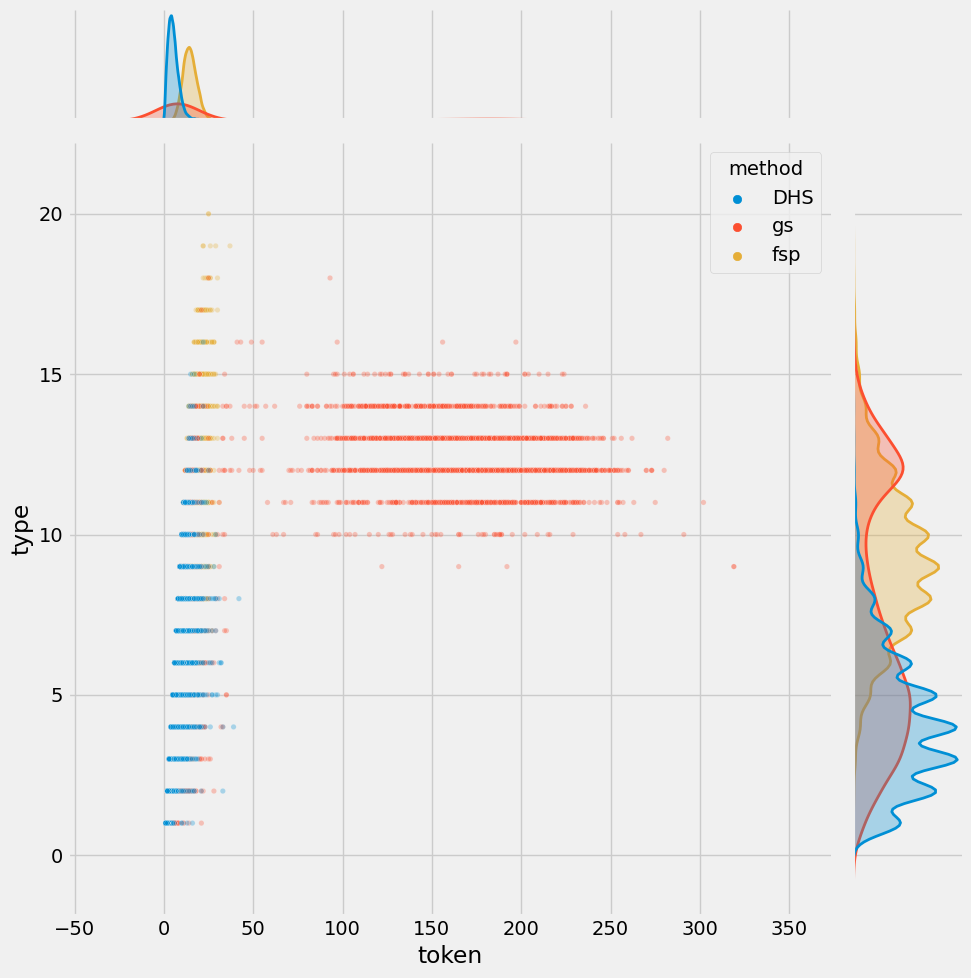

In [ ]:
methods = ['DHS', 'gs', 'fsp']#, 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

with plt.style.context('fivethirtyeight'):
    sns.jointplot(data=plot_df, x='token', y='type', hue='method', hue_order=methods, height=10, ratio=6, #palette=['C0', 'C2'],
                  marginal_kws={'linewidth':2, 'common_grid':False, 'common_norm':False, 'alpha':0.3},
                  joint_kws={'s':15, 'alpha':0.3},
                  )
    plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


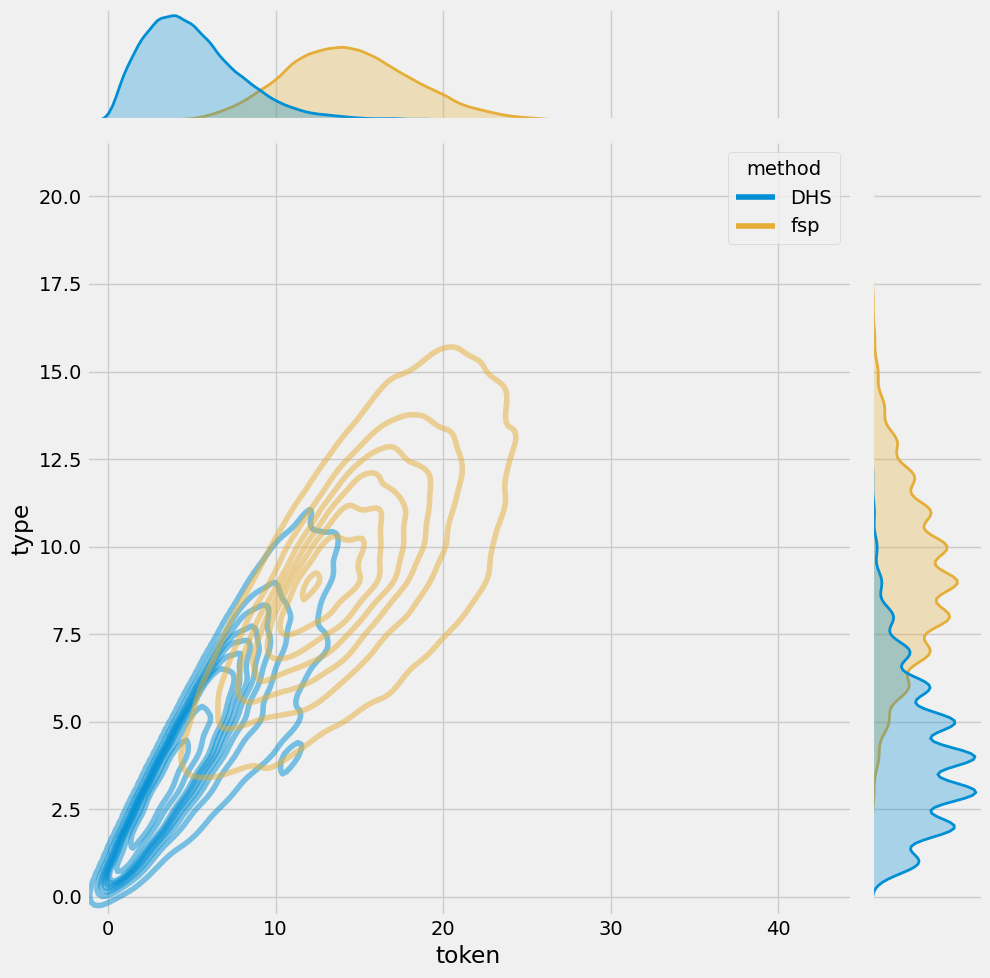

In [ ]:
methods = ['DHS', 'fsp']#, 'sa', 'al']'gs',
plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

with plt.style.context('fivethirtyeight'):
    sns.jointplot(data=plot_df, x='token', y='type', hue='method', hue_order=methods, height=10, ratio=6, kind='kde', palette=['C0', 'C2'],
                  marginal_kws={'linewidth':2, 'common_grid':False, 'common_norm':False, 'alpha':0.3, 'fill':True},
                  joint_kws={'s':15, 'alpha':0.5},
                  )
    plt.show()

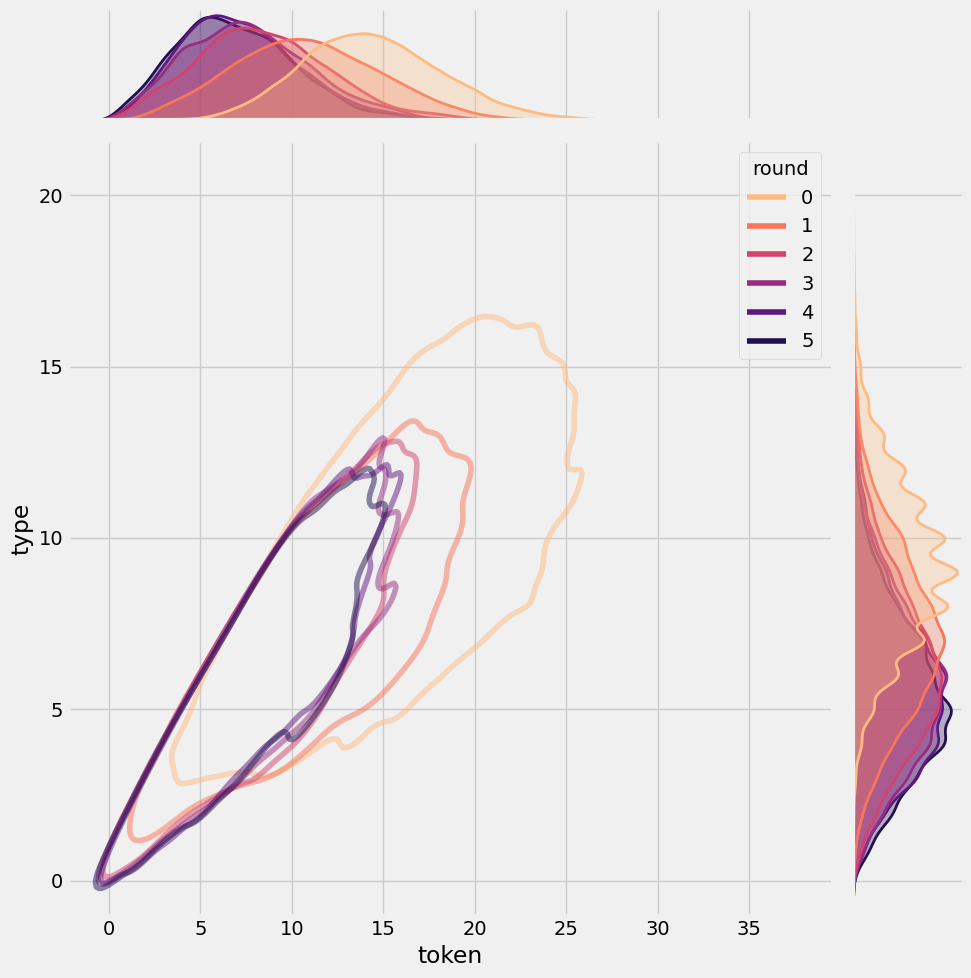

In [ ]:
methods = ['fsp']#, 'sa', 'al']'gs',
plot_df = matches_df[matches_df['method'].isin(methods)].reset_index(drop=True)
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

with plt.style.context('fivethirtyeight'):
    sns.jointplot(data=plot_df, x='token', y='type', hue='round', height=10, ratio=6, kind='kde', palette=custom_palette,
                  marginal_kws={'linewidth':2, 'common_grid':False, 'common_norm':False, 'alpha':0.3, 'fill':True},
                  joint_kws={'alpha':0.5, 'levels':np.array([0.05])},
                  )
    plt.show()

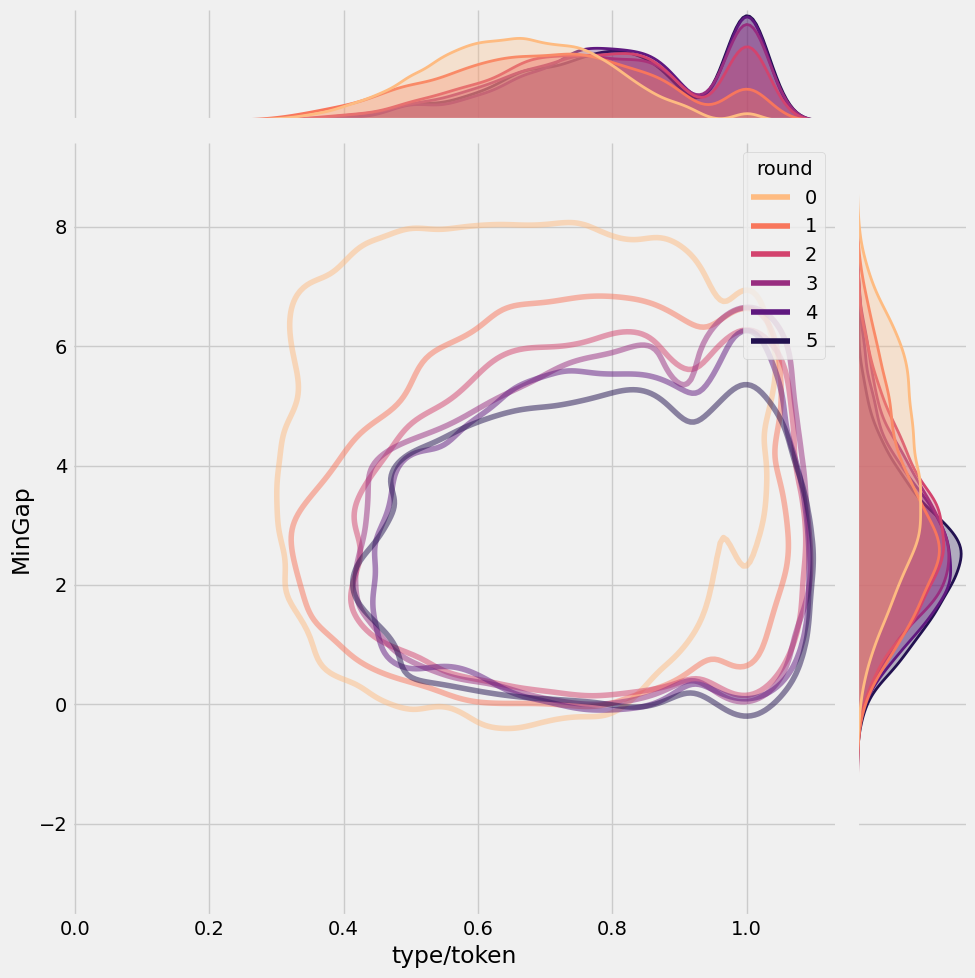

In [ ]:
methods = ['fsp']#, 'sa', 'al']'gs',
plot_df = matches_df[matches_df['method'].isin(methods)].reset_index(drop=True)
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

with plt.style.context('fivethirtyeight'):
    sns.jointplot(data=plot_df, x='type/token', y='OverMax', hue='round', height=10, ratio=6, kind='kde', palette=custom_palette,
                  marginal_kws={'linewidth':2, 'common_grid':False, 'common_norm':False, 'alpha':0.3, 'fill':True},
                  joint_kws={'alpha':0.5, 'levels':np.array([0.05])},
                  )
    plt.ylabel('MinGap')
    plt.show()

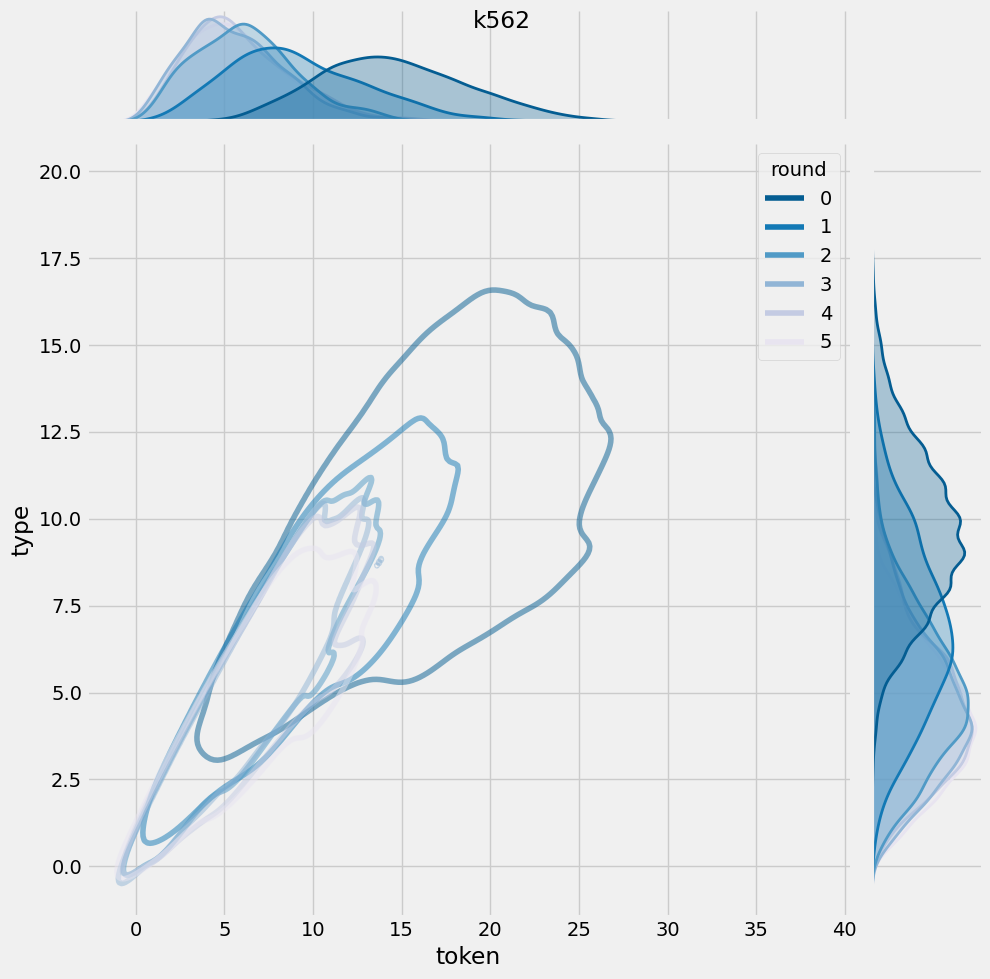

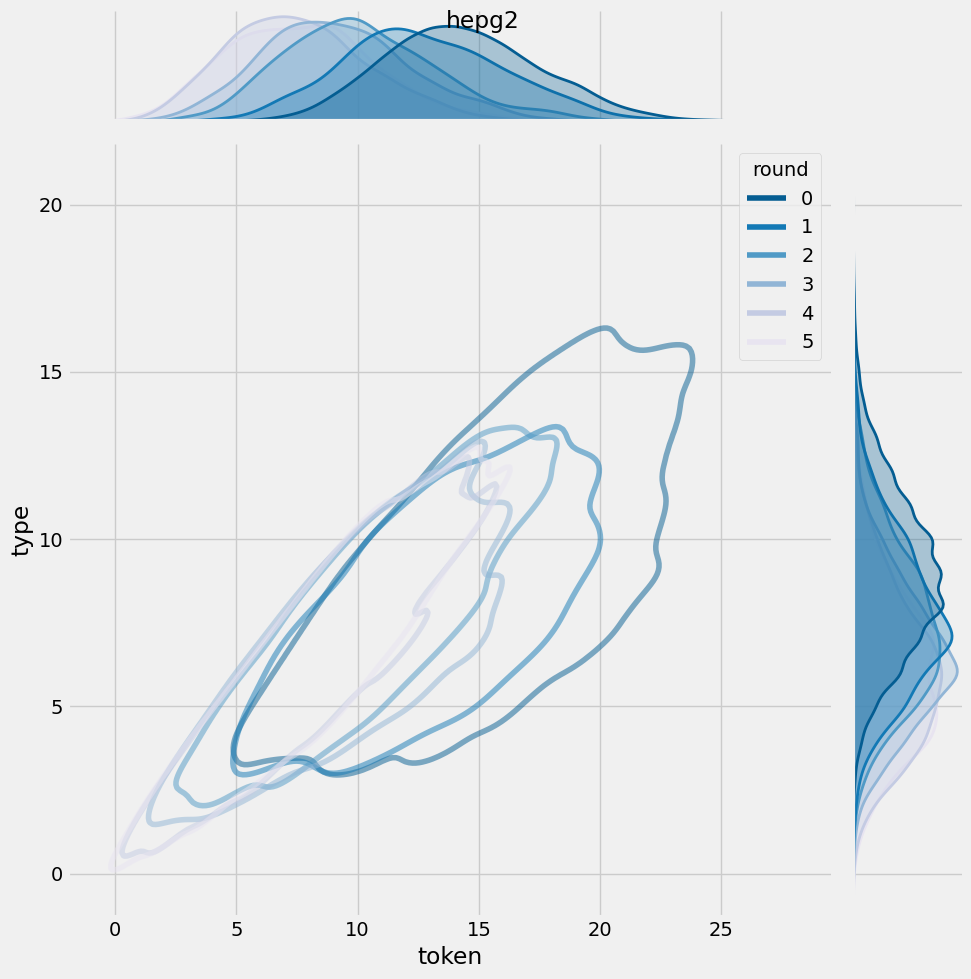

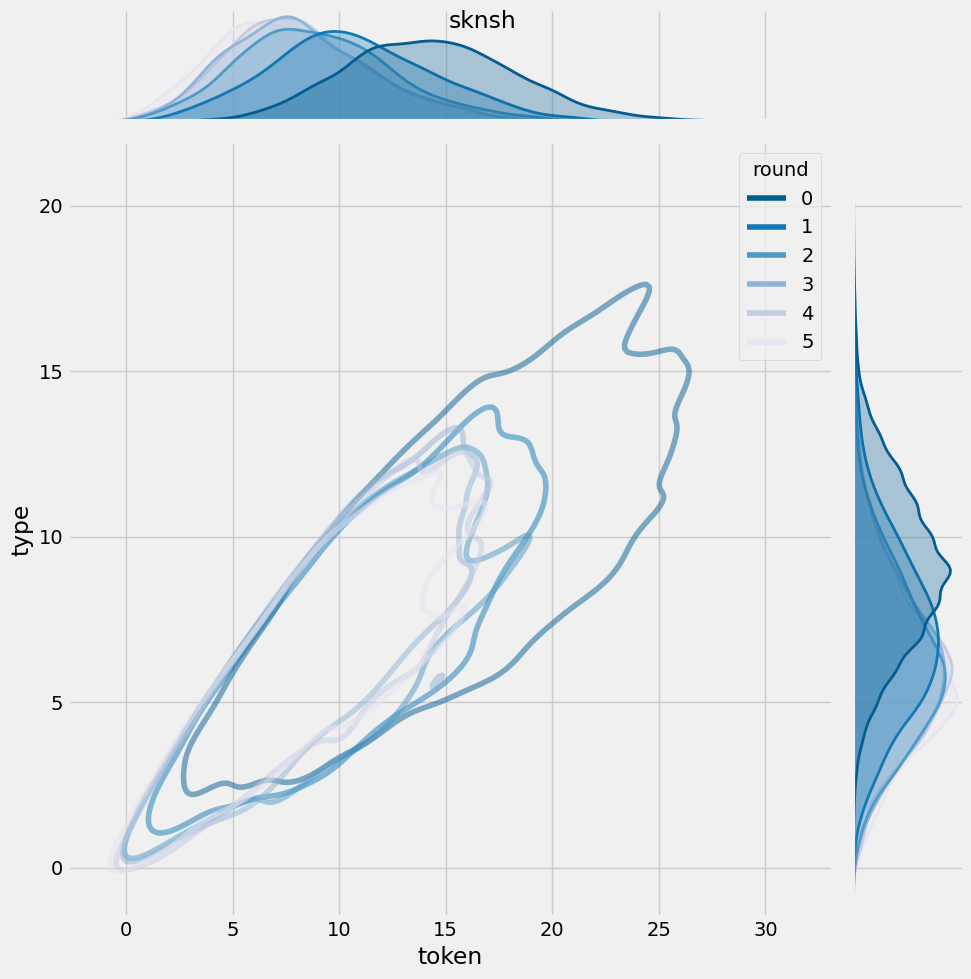

In [ ]:
methods = ['fsp']#, 'sa', 'al']'gs',
for target_cell in target_cells:
    plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['target_cell'] == target_cell)].reset_index(drop=True)
    quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
    plot_df = plot_df[quality_filter].reset_index(drop=True)

    with plt.style.context('fivethirtyeight'):
        g = sns.jointplot(data=plot_df, x='token', y='type', hue='round', height=10, ratio=6, kind='kde', palette=custom_palette,
                    marginal_kws={'linewidth':2, 'common_grid':False, 'common_norm':False, 'alpha':0.3, 'fill':True},
                    joint_kws={'alpha':0.5, 'levels':np.array([0.05])},
                    )
        g.fig.suptitle(target_cell)
        plt.show()

# Contribution coverage

In [ ]:
def vrange(starts, stops):
    stops = np.asarray(stops)
    l = stops - starts # Lengths of each range.
    return np.repeat(stops - l.cumsum(), l) + np.arange(l.sum())

In [ ]:
#--- FIMO min8
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_min8.tsv', sep='\t')
fimo_df = fimo_df[:-3].reset_index(drop=True)

In [ ]:
fimo_df['start'] = fimo_df['start'].to_numpy() - 1 #np.maximum(0, fimo_df['start'].to_numpy() - 1)
fimo_df['stop'] = fimo_df['stop'].to_numpy() + 0 #np.minimum(200, fimo_df['stop'].to_numpy() + 0)
fimo_df['start'] = fimo_df['start'].astype(int)
fimo_df['stop'] = fimo_df['stop'].astype(int)

no_controls_df = boda2_df[boda2_df['method'].notnull()].reset_index(drop=True)

method_subset = ['fsp']#['DHS', 'gs', 'fsp', 'al', 'sa']
#no_controls_df = no_controls_df[no_controls_df['method'].isin(method_subset)].reset_index(drop=True)
no_controls_df = no_controls_df[no_controls_df['method'].isin(method_subset) & (no_controls_df['round'] == 0)].reset_index(drop=True)

In [ ]:
# with open("dhs_seqs.txt", "w") as output:
#     for id, seq in zip(no_controls_df['ID'].tolist(), no_controls_df['sequence']):
#         output.write(f'>{id}\n')
#         output.write(f'{seq}\n')

In [ ]:
A = set(no_controls_df['ID'].tolist())
B = set(fimo_df['sequence_name'].unique())
C = A - A.intersection(B) #
D = B - B.intersection(A)

print(len(C), len(D))

common_seqs = sorted(A.intersection(B))
len(common_seqs)

0 24000


12000

In [ ]:
fimo_df = fimo_df[fimo_df['sequence_name'].isin(common_seqs)].sort_values('sequence_name').reset_index(drop=True)

In [ ]:
no_controls_df = no_controls_df[no_controls_df['ID'].isin(common_seqs)].sort_values('ID').reset_index(drop=True)

sequence_column_name = 'sequence'
contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']

onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in tqdm(no_controls_df[sequence_column_name].tolist())])
contribution_tensor = []
for contribution_column in tqdm(contribution_columns):
    flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
                                      for contributions in no_controls_df[contribution_column]])
    contribution_tensor.append(flat_contributions * onehot_sequences)
contribution_tensor = torch.stack(contribution_tensor)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
%%time

starts = fimo_df.groupby('sequence_name').start.apply(list).reset_index()
stops = fimo_df.groupby('sequence_name').stop.apply(list).reset_index()

stops = stops['stop'].tolist()
starts = starts['start'].tolist()

CPU times: user 662 ms, sys: 5 ms, total: 667 ms
Wall time: 662 ms


In [ ]:
abs_flat_contribution_tensor = contribution_tensor.sum(dim=2).abs()

#abs_flat_contribution_tensor[abs_flat_contribution_tensor < 0.1] = 0
#abs_flat_contribution_tensor = torch.ones_like(abs_flat_contribution_tensor)

In [ ]:
num_sequences = len(no_controls_df)

all_covered_contributions = []
for cell_idx in range(3):
    covered_contributions = []
    for seq_idx in tqdm(range(num_sequences)):
        seq_starts = starts[seq_idx]
        seq_stops = stops[seq_idx]
        idxs_covered = np.unique(vrange(seq_starts, seq_stops))
        covered_contributions.append(abs_flat_contribution_tensor[cell_idx, seq_idx, idxs_covered].sum().item())

    all_covered_contributions.append(torch.Tensor(covered_contributions))

all_covered_contributions = torch.stack(all_covered_contributions)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
covered_pcts = all_covered_contributions / (abs_flat_contribution_tensor.sum(dim=-1) + 1e-6)
print(covered_pcts.mean(dim=-1))
print(covered_pcts.mean(dim=-1).mean())

tensor([0.5032, 0.5924, 0.5268])
tensor(0.5408)


In [ ]:
covered_pcts = all_covered_contributions / (abs_flat_contribution_tensor.sum(dim=-1) + 1e-6)
print(covered_pcts.mean(dim=-1))
print(covered_pcts.mean(dim=-1).mean())

tensor([0.5139, 0.5695, 0.4938])

In [ ]:
np.mean([0.5139, 0.5695, 0.4938])

0.5257333333333334

In [ ]:
covered_pcts = all_covered_contributions / (abs_flat_contribution_tensor.sum(dim=-1) + 1e-6)
print(covered_pcts.mean(dim=-1))
print(covered_pcts.mean(dim=-1).mean())

tensor([0.4735, 0.5606, 0.4921])

In [ ]:
np.mean([0.4735, 0.5606, 0.4921])

0.5087333333333334

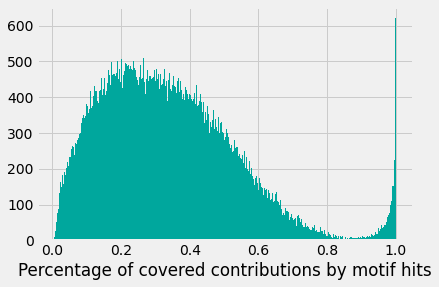

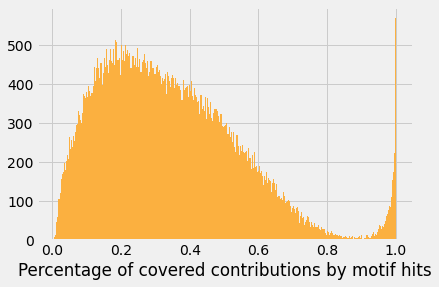

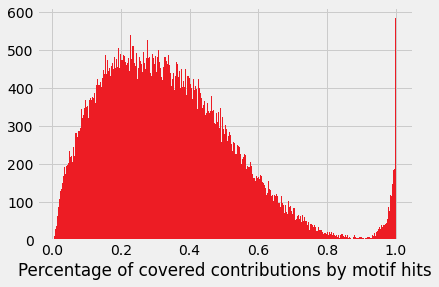

In [ ]:
cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

with plt.style.context('fivethirtyeight'):
    for cell_idx in range(3):
        plt.hist(covered_pcts[cell_idx,...].numpy(), bins=500, color=cell_colors[cell_idx])
        plt.xlabel('Percentage of covered contributions by motif hits')
        plt.show()

In [ ]:
covered_contributions, abs_flat_contribution_tensor[cell_idx, seq_idx, :].sum().item()

([1.3221349716186523], 4.600576877593994)

In [ ]:
abs_flat_contribution_tensor[cell_idx, seq_idx, idxs_covered].sum().item()

1.3221349716186523

In [ ]:
start_stops

array([[154., 168.],
       [ 27.,  41.],
       [ 27.,  41.],
       [157., 166.],
       [154., 162.],
       [117., 131.],
       [120., 129.],
       [ 20.,  34.],
       [ 20.,  34.],
       [ 96., 104.],
       [121., 130.]])

# DHS STREME

In [ ]:
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/dhs_fimo.tsv', sep='\t')
fimo_df = fimo_df[:-3].reset_index(drop=True)

fimo_df['start'] = fimo_df['start'].to_numpy() - 1 #np.maximum(0, fimo_df['start'].to_numpy() - 1)
fimo_df['stop'] = fimo_df['stop'].to_numpy() + 0 #np.minimum(200, fimo_df['stop'].to_numpy() + 0)
fimo_df['start'] = fimo_df['start'].astype(int)
fimo_df['stop'] = fimo_df['stop'].astype(int)


no_controls_df = boda2_df[boda2_df['method'].notnull()].reset_index(drop=True)

method_subset = ['DHS']
no_controls_df = no_controls_df[no_controls_df['method'].isin(method_subset) & (no_controls_df['round'] == 0)].reset_index(drop=True)

In [ ]:
no_controls_df = no_controls_df[no_controls_df['OverMax'] >= 3.0].reset_index(drop=True)

In [ ]:
A = set(no_controls_df['ID'].tolist())
B = set(fimo_df['sequence_name'].unique())
C = A - A.intersection(B) #
D = B - B.intersection(A)

print(len(C), len(D))

common_seqs = sorted(A.intersection(B))
len(common_seqs)

30 10711


777

In [ ]:
no_controls_df = no_controls_df[no_controls_df['ID'].isin(common_seqs)].sort_values('ID').reset_index(drop=True)

sequence_column_name = 'sequence'
contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']

onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in tqdm(no_controls_df[sequence_column_name].tolist())])
contribution_tensor = []
for contribution_column in tqdm(contribution_columns):
    flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
                                      for contributions in no_controls_df[contribution_column]])
    contribution_tensor.append(flat_contributions * onehot_sequences)
contribution_tensor = torch.stack(contribution_tensor)

  0%|          | 0/777 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
fimo_df = fimo_df[fimo_df['sequence_name'].isin(common_seqs)].sort_values('sequence_name').reset_index(drop=True)

In [ ]:
%%time

starts = fimo_df.groupby('sequence_name').start.apply(list).reset_index()
stops = fimo_df.groupby('sequence_name').stop.apply(list).reset_index()

stops = stops['stop'].tolist()
starts = starts['start'].tolist()

CPU times: user 36.9 ms, sys: 944 µs, total: 37.8 ms
Wall time: 39.3 ms


In [ ]:
abs_flat_contribution_tensor = contribution_tensor.sum(dim=2).abs()

#abs_flat_contribution_tensor[abs_flat_contribution_tensor < 0.1] = 0
abs_flat_contribution_tensor = torch.ones_like(abs_flat_contribution_tensor)

In [ ]:
num_sequences = len(no_controls_df)

all_covered_contributions = []
for cell_idx in range(3):
    covered_contributions = []
    for seq_idx in tqdm(range(num_sequences)):
        seq_starts = starts[seq_idx]
        seq_stops = stops[seq_idx]
        idxs_covered = np.unique(vrange(seq_starts, seq_stops))
        covered_contributions.append(abs_flat_contribution_tensor[cell_idx, seq_idx, idxs_covered].sum().item())

    all_covered_contributions.append(torch.Tensor(covered_contributions))

all_covered_contributions = torch.stack(all_covered_contributions)

  0%|          | 0/777 [00:00<?, ?it/s]

  0%|          | 0/777 [00:00<?, ?it/s]

  0%|          | 0/777 [00:00<?, ?it/s]

In [ ]:
covered_pcts = all_covered_contributions / (abs_flat_contribution_tensor.sum(dim=-1) + 1e-6)
print(covered_pcts.mean(dim=-1))
print(covered_pcts.mean(dim=-1).mean())

tensor([0.1973, 0.1973, 0.1973])
tensor(0.1973)


In [ ]:
covered_pcts = all_covered_contributions / (abs_flat_contribution_tensor.sum(dim=-1) + 1e-6)
print(covered_pcts.mean(dim=-1))
print(covered_pcts.mean(dim=-1).mean())

tensor([0.1793, 0.1793, 0.1793])
tensor(0.1793)
